In [1]:
import numpy as np
from numpy import mean
from numpy import std
from numpy import dstack

import pandas as pd
from pandas import read_csv
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from tensorflow.keras.layers import Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Input, Dropout, Flatten, BatchNormalization
from tensorflow.keras.layers import concatenate, Dropout
from keras.utils import to_categorical
from tensorflow.keras import optimizers
import seaborn as sns

In [2]:
# load a single file as a numpy array
def load_file(filepath):
    dataframe = read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values
 
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = dstack(loaded)
	return loaded
 
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
	filepath = prefix + group + '/Inertial Signals/'
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(prefix + group + '/y_'+group+'.txt')
	return X, y

# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + 'C:/Users/khw/2023DeepLearning/human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + 'C:/Users/khw/2023DeepLearning/human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/')
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print("trainX shape: ",trainX.shape)
    print("trainy shape: ", trainy.shape)
    print("testX shape: ", testX.shape)
    print("testy shape: ", testy.shape)
    return trainX, trainy, testX, testy

In [3]:
trainX, trainy, testX, testy = load_dataset()

trainX shape:  (7352, 128, 9)
trainy shape:  (7352, 6)
testX shape:  (2947, 128, 9)
testy shape:  (2947, 6)


In [4]:
## set number of epochs and batch size
batch_size = 64
validation_split = 0.2

In [5]:

n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=7, activation='relu', padding='same', input_shape=(n_timesteps, n_features)))
model.add(MaxPooling1D(2))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same', input_shape=(n_timesteps, n_features)))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same', input_shape=(n_timesteps, n_features)))
model.add(MaxPooling1D(2))
model.add(Conv1D(filters=256, kernel_size=3, activation='relu', padding='same', input_shape=(n_timesteps, n_features)))
model.add(Conv1D(filters=256, kernel_size=3, activation='relu', padding='same', input_shape=(n_timesteps, n_features)))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))


In [6]:
from keras.optimizers import Adam


model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])

In [7]:
# fit network
train_epochs = 10
history = model.fit(trainX, trainy, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_split=validation_split, shuffle=True)

Epoch 1/10
92/92 [==============================] - 40s 375ms/step - loss: 1.0533 - accuracy: 0.5195 - val_loss: 0.6716 - val_accuracy: 0.7437
Epoch 2/10
92/92 [==============================] - 23s 250ms/step - loss: 0.4058 - accuracy: 0.8470 - val_loss: 0.2879 - val_accuracy: 0.9116
Epoch 3/10
92/92 [==============================] - 13s 144ms/step - loss: 0.1959 - accuracy: 0.9316 - val_loss: 0.3361 - val_accuracy: 0.9225
Epoch 4/10
92/92 [==============================] - 14s 152ms/step - loss: 0.1361 - accuracy: 0.9485 - val_loss: 0.3242 - val_accuracy: 0.9021
Epoch 5/10
92/92 [==============================] - 17s 185ms/step - loss: 0.1325 - accuracy: 0.9469 - val_loss: 0.4922 - val_accuracy: 0.8973
Epoch 6/10
92/92 [==============================] - 23s 247ms/step - loss: 0.1099 - accuracy: 0.9544 - val_loss: 1.0733 - val_accuracy: 0.9116
Epoch 7/10
92/92 [==============================] - 32s 349ms/step - loss: 0.1229 - accuracy: 0.9500 - val_loss: 0.3193 - val_accuracy: 0.9014

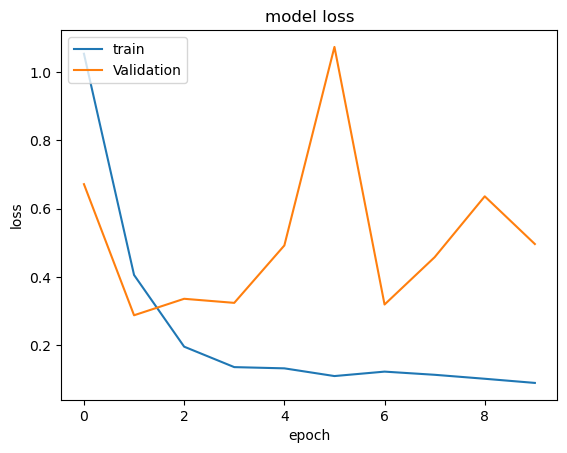

In [8]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [9]:
# evaluate model
test_loss, test_accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
print("Accuracy of the CNN model", test_accuracy)
# Get the predictions for the test set
predictions = model.predict(testX)

Accuracy of the CNN model 0.876823902130127
93/93 [==============================] - 3s 24ms/step


In [10]:
predictions

array([[7.3591838e-13, 5.1983834e-10, 1.3650119e-13, 1.8264594e-03,
        9.9817359e-01, 1.3217685e-10],
       [1.1590203e-12, 9.0542518e-10, 2.5817030e-13, 2.0577447e-03,
        9.9794227e-01, 2.0669755e-10],
       [1.2297237e-13, 8.1509667e-11, 2.0607934e-14, 1.4185605e-03,
        9.9858141e-01, 4.0699350e-11],
       ...,
       [4.5902935e-13, 1.0000000e+00, 2.0178473e-13, 1.4121298e-14,
        4.0512768e-16, 7.2035849e-15],
       [3.0106405e-13, 1.0000000e+00, 1.2544784e-13, 3.3481768e-15,
        7.9438502e-17, 1.8145692e-15],
       [1.7387391e-14, 1.0000000e+00, 7.4682598e-15, 1.1285752e-16,
        1.4087184e-18, 7.6436074e-17]], dtype=float32)

In [11]:
def display_results(testy,predictions,classNames):
    y_test=np.argmax(testy, axis=1)
    y_scores=np.argmax(predictions, axis=1)
    classes = len(classNames)
    cm = confusion_matrix(y_test, y_scores)
    print("**** Confusion Matrix ****")
    print(cm)
    print("**** Classification Report ****")
    print(classification_report(y_test, y_scores, target_names=classNames))
    con = np.zeros((classes,classes))
    for x in range(classes):
        for y in range(classes):
            con[x,y] = cm[x,y] #/np.sum(cm[x,:])

    plt.figure(figsize=(10,8))
    df = sns.heatmap(con, annot=True, fmt='g', cmap='Blues',xticklabels= classNames , yticklabels= classNames)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

**** Confusion Matrix ****
[[439  31  26   0   0   0]
 [  0 447  24   0   0   0]
 [  0   3 417   0   0   0]
 [  0  25   0 310 156   0]
 [  0  49   0  22 461   0]
 [  0  27   0   0   0 510]]
**** Classification Report ****
              precision    recall  f1-score   support

           1       1.00      0.89      0.94       496
           2       0.77      0.95      0.85       471
           3       0.89      0.99      0.94       420
           4       0.93      0.63      0.75       491
           5       0.75      0.87      0.80       532
           6       1.00      0.95      0.97       537

    accuracy                           0.88      2947
   macro avg       0.89      0.88      0.88      2947
weighted avg       0.89      0.88      0.88      2947



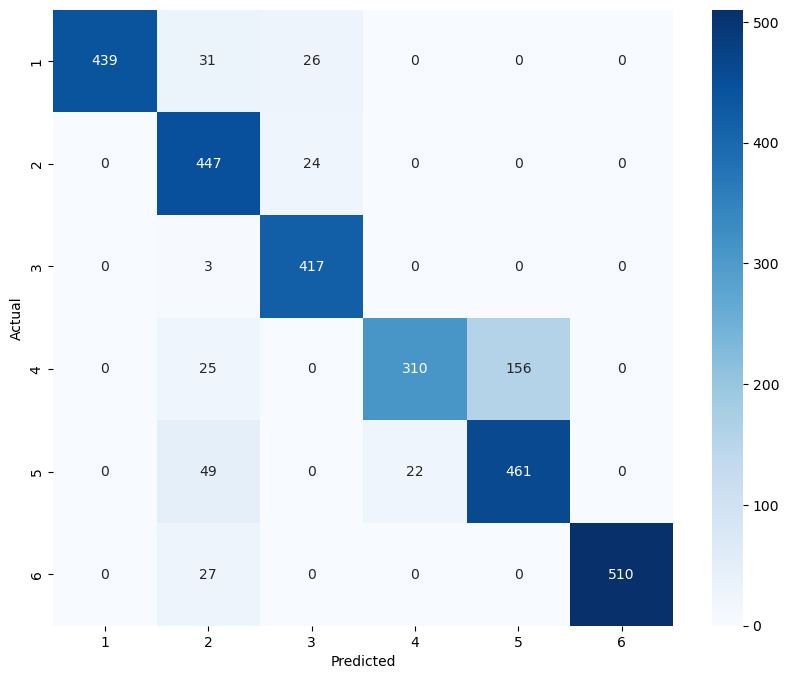

In [12]:
from sklearn.metrics import confusion_matrix, classification_report
classNames=["1","2","3","4","5","6"]
display_results(testy,predictions,classNames)